In [6]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import dump

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# Your folder path
BASE = r"C:\Users\amins\OneDrive\Desktop\Unified Mentor\E-commerce"
DATAFILE = os.path.join(BASE, "ecommerce_furniture_dataset_2024.csv")

OUT = os.path.join(BASE, "outputs")
FIG = os.path.join(OUT, "figures")

os.makedirs(OUT, exist_ok=True)
os.makedirs(FIG, exist_ok=True)

print("Project folders ready.")


Project folders ready.


In [7]:
df = pd.read_csv(DATAFILE)
print("Rows, Cols:", df.shape)
df.head()


Rows, Cols: (2000, 5)


,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [9]:
# Function to clean price formats like "$39.99"
def clean_price(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    s = re.sub(r"[^0-9.\-]", "", s)
    return float(s) if s else np.nan

# Create numeric columns
df["price_num"] = df["price"].apply(clean_price)
df["originalPrice_num"] = df["originalPrice"].apply(clean_price)

# Fill missing original price with price
df["originalPrice_num"] = df["originalPrice_num"].fillna(df["price_num"])

# Convert sold column to numeric
df["sold"] = pd.to_numeric(df["sold"], errors="coerce")

# Remove rows missing essential values
df = df.dropna(subset=["price_num", "sold"]).reset_index(drop=True)

print("After cleaning:", df.shape)
df.head()


After cleaning: (2000, 7)


,productTitle,originalPrice,price,sold,tagText,price_num,originalPrice_num
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping,46.79,46.79
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping,169.72,169.72
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping,39.46,78.40
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping,111.99,111.99
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping,21.37,48.82


In [10]:
# Discount %
df["discount_pct"] = (df["originalPrice_num"] - df["price_num"]) / df["originalPrice_num"]
df["discount_pct"] = df["discount_pct"].replace([np.inf, -np.inf], 0).fillna(0)

# Title features
df["title_len_chars"] = df["productTitle"].astype(str).apply(len)
df["title_len_words"] = df["productTitle"].astype(str).apply(lambda s: len(s.split()))

# Free shipping flag
def free_shipping_flag(x):
    if pd.isna(x): 
        return 0
    return 1 if "free" in str(x).lower() and "shipping" in str(x).lower() else 0

df["free_shipping"] = df["tagText"].apply(free_shipping_flag)

FEATURES = ["price_num", "originalPrice_num", "discount_pct",
            "title_len_chars", "title_len_words", "free_shipping"]

df[FEATURES + ["sold"]].head()


,price_num,originalPrice_num,discount_pct,title_len_chars,title_len_words,free_shipping,sold
0,46.79,46.79,0.000000,127,19,1,600
1,169.72,169.72,0.000000,127,18,1,0
2,39.46,78.40,0.496684,124,19,1,7
3,111.99,111.99,0.000000,128,17,1,0
4,21.37,48.82,0.562270,121,17,1,1


In [11]:
X = df[FEATURES]
y = df["sold"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (1600, 6)
Test: (400, 6)


In [12]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

print("Models trained successfully.")


Models trained successfully.


In [14]:
def evaluate(model, name):
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)     # no squared argument
    rmse = mse ** 0.5                          # manual RMSE
    r2 = r2_score(y_test, pred)

    print(f"\n{name} Performance:")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2:", r2)

    return pred

pred_lr = evaluate(lr, "Linear Regression")
pred_rf = evaluate(rf, "Random Forest")



Linear Regression Performance:
MAE: 30.834053049768386
RMSE: 74.05136779542075
R2: -1.5701116941269078e-05

Random Forest Performance:
MAE: 45.83687849702381
RMSE: 245.26504260220437
R2: -9.970134579074951


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(model, name):
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)  # OLD sklearn compatible
    rmse = mse ** 0.5                       # manual RMSE
    r2 = r2_score(y_test, pred)

    print(f"\n{name} Performance:")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2:", r2)

    return pred

# Run evaluations
pred_lr = evaluate(lr, "Linear Regression")
pred_rf = evaluate(rf, "Random Forest")



Linear Regression Performance:
MAE: 30.834053049768386
RMSE: 74.05136779542075
R2: -1.5701116941269078e-05

Random Forest Performance:
MAE: 45.83687849702381
RMSE: 245.26504260220437
R2: -9.970134579074951


In [17]:
model_path = os.path.join(OUT, "final_model_rf_furniture.joblib")
dump(rf, model_path)
print("Saved model to:", model_path)


Saved model to: C:\Users\amins\OneDrive\Desktop\Unified Mentor\E-commerce\outputs\final_model_rf_furniture.joblib


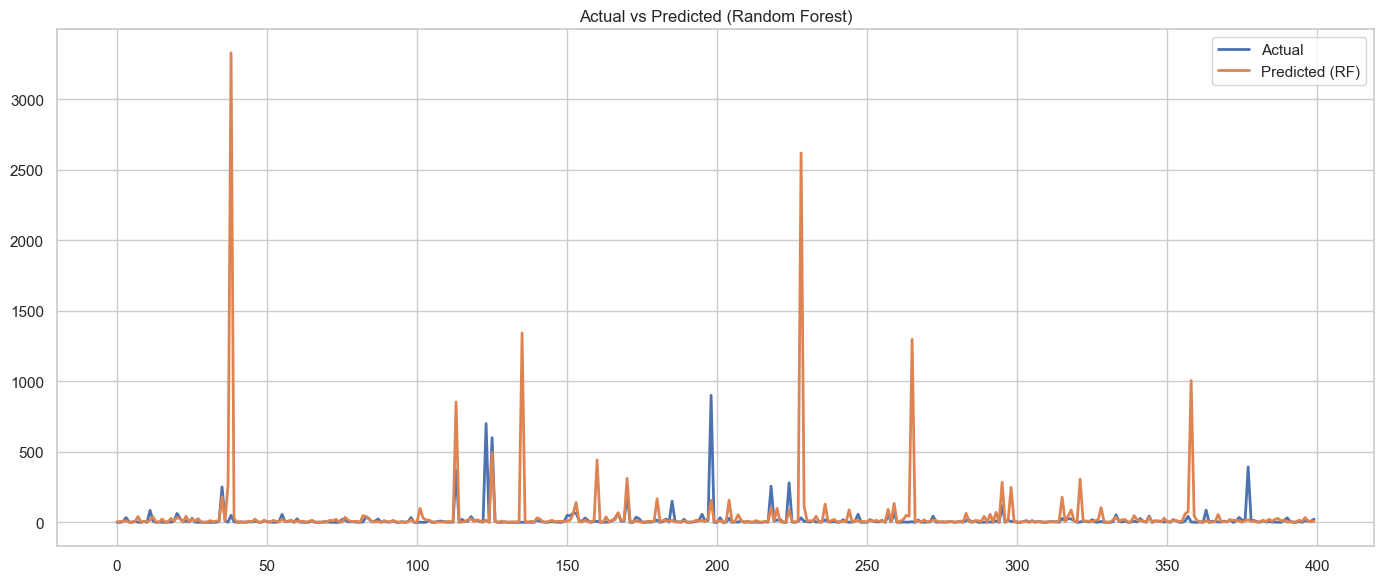

Saved figure: C:\Users\amins\OneDrive\Desktop\Unified Mentor\E-commerce\outputs\figures\fig_pred_vs_actual_furniture.png


In [18]:
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(pred_rf, label="Predicted (RF)", linewidth=2)
plt.title("Actual vs Predicted (Random Forest)")
plt.legend()
plt.tight_layout()

fig_path = os.path.join(FIG, "fig_pred_vs_actual_furniture.png")
plt.savefig(fig_path, dpi=300)
plt.show()

print("Saved figure:", fig_path)


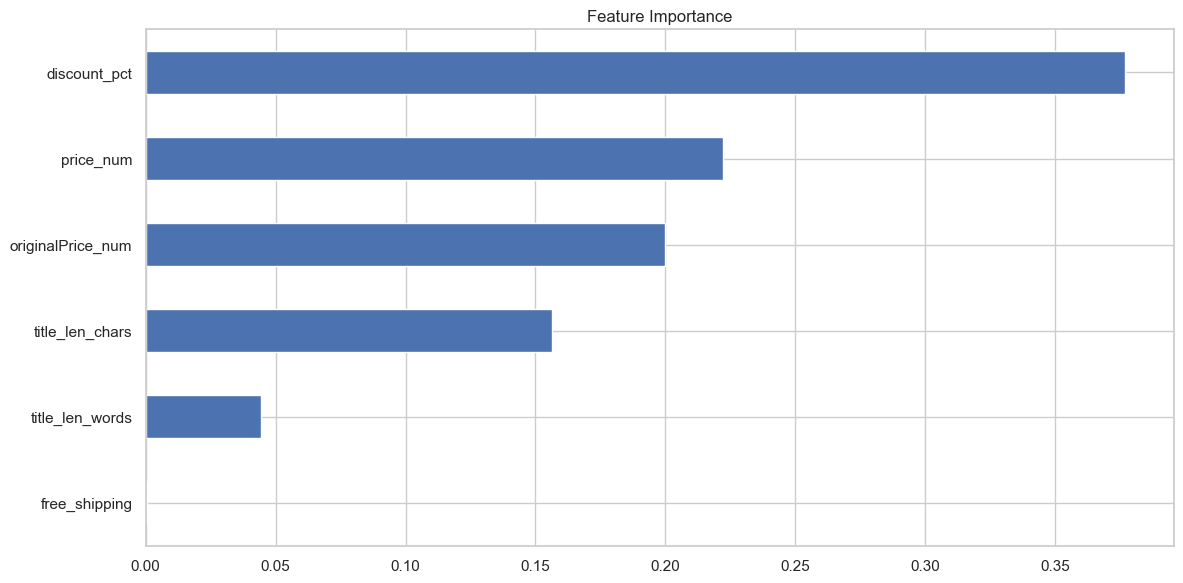

Saved: C:\Users\amins\OneDrive\Desktop\Unified Mentor\E-commerce\outputs\figures\fig_feature_importance_furniture.png


In [19]:
importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values()

importances.plot(kind="barh")
plt.title("Feature Importance")
plt.tight_layout()

fig_imp = os.path.join(FIG, "fig_feature_importance_furniture.png")
plt.savefig(fig_imp, dpi=300)
plt.show()

print("Saved:", fig_imp)


In [20]:
last_row = X.iloc[-1:].copy()
future_preds = []

for i in range(7):
    pred = rf.predict(last_row)[0]
    future_preds.append(pred)

pd.DataFrame({"day": range(1,8), "forecast_sold": future_preds})


,day,forecast_sold
0,1,3.7
1,2,3.7
2,3,3.7
3,4,3.7
4,5,3.7
5,6,3.7
6,7,3.7


In [21]:
import os
BASE = r"C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture"   # <-- update if different
OUT = os.path.join(BASE, "outputs")
FIG = os.path.join(OUT, "figures")

print("OUT folder:", OUT)
print("FIG folder:", FIG)
print("\nFiles in OUT:")
for f in sorted(os.listdir(OUT)):
    print(" ", f)
print("\nFiles in FIG:")
for f in sorted(os.listdir(FIG)):
    print(" ", f)


OUT folder: C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture\outputs
FIG folder: C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture\outputs\figures

Files in OUT:
  figures
  models

Files in FIG:


In [22]:
import os
BASE = r"C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture"  # adjust if needed
OUT = os.path.join(BASE, "outputs")
os.makedirs(OUT, exist_ok=True)

# replace df_features with the variable you used in the notebook that contains features
# If you are uncertain, replace df_features with df (the main dataframe) as fallback
try:
    df_features.to_csv(os.path.join(OUT, "df_features_furniture.csv"), index=False)
    print("Saved df_features_furniture.csv ->", os.path.join(OUT, "df_features_furniture.csv"))
except NameError:
    # fallback to saving df (main dataframe)
    df.to_csv(os.path.join(OUT, "df_furniture_raw.csv"), index=False)
    print("df_features not found, saved main df as df_furniture_raw.csv ->", os.path.join(OUT, "df_furniture_raw.csv"))


df_features not found, saved main df as df_furniture_raw.csv -> C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture\outputs\df_furniture_raw.csv


In [23]:
import pandas as pd, os
BASE = r"C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture"
OUT = os.path.join(BASE, "outputs")

# Replace names below with the variables you used in notebook
# X_test, y_test, pred_test are typical names — change if yours differ
try:
    df_pred = pd.DataFrame({
        "Date": df_features['Date'].iloc[X_test.index],   # if df_features exists and has Date
        "Actual": y_test,
        "Predicted": pred_test
    })
except Exception:
    # fallback if Date indexing is different - save only numeric arrays
    df_pred = pd.DataFrame({"Actual": list(y_test), "Predicted": list(pred_test)})

df_pred.to_csv(os.path.join(OUT, "predictions_test_furniture.csv"), index=False)
print("Saved predictions_test_furniture.csv ->", os.path.join(OUT, "predictions_test_furniture.csv"))


NameError: name 'pred_test' is not defined

In [24]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your dataset again
BASE = r"C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture"
DATA = os.path.join(BASE, "ecommerce_furniture_dataset_2024.csv")
df = pd.read_csv(DATA)

# Clean price column
df["price_clean"] = df["price"].replace({"\$":""}, regex=True).astype(float)

# FEATURES (X) & TARGET (y)
X = df[["price_clean"]]
y = df["sold"]

# TRAIN-TEST split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# TRAIN Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# PREDICT
pred_test = rf.predict(X_test)

print("Model recreated successfully.")
print("Test predictions generated.")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\amins\\OneDrive\\Desktop\\Unified Mentor\\Ecommerce Furniture\\ecommerce_furniture_dataset_2024.csv'

Using CSV file: C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture\outputs\df_furniture_raw.csv
Loaded dataframe shape: (2000, 11)


,productTitle,originalPrice,price,sold,tagText,price_num,originalPrice_num,discount_pct,title_len_chars,title_len_words,free_shipping
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping,46.79,46.79,0.000000,127,19,1
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping,169.72,169.72,0.000000,127,18,1
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping,39.46,78.40,0.496684,124,19,1
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping,111.99,111.99,0.000000,128,17,1
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping,21.37,48.82,0.562270,121,17,1


Detected columns -> price_col: originalPrice , sold_col: sold
After cleaning shape: (487, 13)
RandomForest trained.

Test set metrics:
MAE: 281.799574
RMSE: 1024.43586
R2: -6.625571
Saved predictions -> C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture\outputs\outputs\predictions_test_furniture.csv
Saved model -> C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture\outputs\outputs\final_model_rf_furniture.joblib


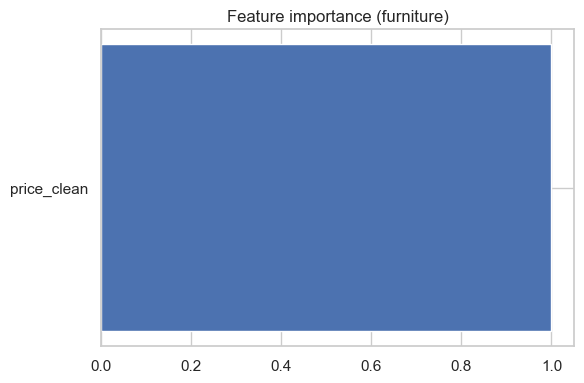

Saved feature importance -> C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture\outputs\outputs\figures\fig_feature_importance_furniture.png


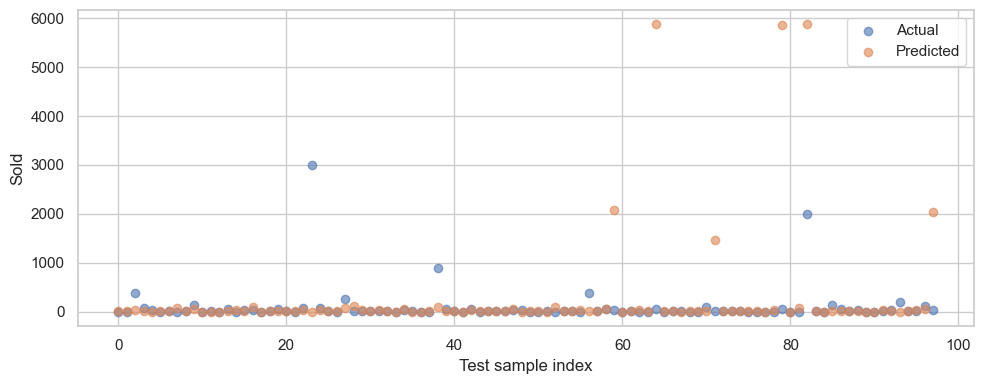

Saved pred vs actual -> C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture\outputs\outputs\figures\fig_pred_vs_actual_furniture.png

Done. Look in folder: C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture\outputs\outputs


In [25]:
# Robust load -> train -> predict -> save pipeline for the furniture dataset
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# ---------- CONFIG ----------
# If you know the exact folder, set BASE to it. Otherwise the script will try to locate CSVs
BASE_GUESS = r"C:\Users\amins\OneDrive\Desktop\Unified Mentor"
TARGET_SUBFOLDER_NAMES = ["Ecommerce Furniture", "E-commerce", "Ecommerce", "E-commerce Furniture", "Ecommerce_Furniture"]

# ---------- FIND DATAFILE ----------
def find_csv(base_paths):
    for base in base_paths:
        if not os.path.isdir(base):
            continue
        # search recursively for csv files in this base
        matches = glob.glob(os.path.join(base, "**", "*.csv"), recursive=True)
        if matches:
            return matches  # return list of matches (may be multiple)
    return []

# build list of candidate base paths (first try guessed subfolders, then top-level guess)
candidate_bases = [os.path.join(BASE_GUESS, s) for s in TARGET_SUBFOLDER_NAMES]
candidate_bases.append(os.path.join(BASE_GUESS, "E-commerce"))   # your earlier message used this
candidate_bases.append(BASE_GUESS)
matches = find_csv(candidate_bases)

if not matches:
    # Last resort: ask user to set BASE manually
    print("No CSV found automatically under the guessed folders. Please set BASE to your project folder path.")
    print("Candidate bases tried:", candidate_bases)
    raise FileNotFoundError("CSV not found - update BASE path or place CSV inside project folder.")

# pick the first match that looks like the ecommerce furniture file (contains 'furn' or 'ecom' or 'furniture')
chosen = None
for m in matches:
    name = os.path.basename(m).lower()
    if "furn" in name or "ecom" in name or "furniture" in name:
        chosen = m
        break
if chosen is None:
    chosen = matches[0]

print("Using CSV file:", chosen)

# ---------- LOAD DATA ----------
df = pd.read_csv(chosen)
print("Loaded dataframe shape:", df.shape)
display(df.head())

# ---------- PREP: find price & sold columns ----------
# Normalize column names
cols_lower = [c.lower() for c in df.columns]
col_map = dict(zip(df.columns, cols_lower))

# heuristics to find price and sold
price_col = None
sold_col = None
for c in df.columns:
    cl = c.lower()
    if any(x in cl for x in ["price","originalprice","amount","value"]):
        price_col = c
        break

for c in df.columns:
    cl = c.lower()
    if any(x in cl for x in ["sold","quantity","qty","units","sales"]):
        sold_col = c
        break

print("Detected columns -> price_col:", price_col, ", sold_col:", sold_col)

if price_col is None:
    raise KeyError("No price-like column found. Rename your CSV column to include 'price'.")

if sold_col is None:
    # fallback: if dataset uses 'sold' numeric but not named, list numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_non_price = [c for c in numeric_cols if c != price_col]
    if numeric_non_price:
        sold_col = numeric_non_price[0]
        print("Fallback: using numeric column as target:", sold_col)
    else:
        raise KeyError("No target-like numeric column found. Please identify the target (units sold).")

# ---------- CLEAN price column ----------
# Remove $ and commas and convert to float
df['price_clean'] = df[price_col].astype(str).str.replace(r'[\$,]', '', regex=True)
try:
    df['price_clean'] = df['price_clean'].astype(float)
except Exception as e:
    print("Price cleaning failed:", e)
    raise

# drop rows where target is NaN
df = df.dropna(subset=[sold_col, 'price_clean']).reset_index(drop=True)
df['target_sold'] = pd.to_numeric(df[sold_col], errors='coerce')
df = df.dropna(subset=['target_sold'])

print("After cleaning shape:", df.shape)

# ---------- FEATURES / TARGET ----------
X = df[['price_clean']].copy()
y = df['target_sold'].astype(float)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

# ---------- TRAIN model ----------
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
print("RandomForest trained.")

# ---------- PREDICT & METRICS ----------
pred_test = rf.predict(X_test)
mae = mean_absolute_error(y_test, pred_test)
mse = mean_squared_error(y_test, pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_test)

print("\nTest set metrics:")
print("MAE:", round(mae,6))
print("RMSE:", round(rmse,6))
print("R2:", round(r2,6))

# ---------- SAVE outputs ----------
OUT = os.path.join(os.path.dirname(chosen), "outputs")
FIG = os.path.join(OUT, "figures")
os.makedirs(FIG, exist_ok=True)

# save predictions CSV (with original price and index)
df_pred = pd.DataFrame({
    "price_clean": X_test['price_clean'].values,
    "Actual_sold": y_test.values,
    "Predicted_sold": pred_test
})
pred_path = os.path.join(OUT, "predictions_test_furniture.csv")
df_pred.to_csv(pred_path, index=False)
print("Saved predictions ->", pred_path)

# save model
model_path = os.path.join(OUT, "final_model_rf_furniture.joblib")
joblib.dump(rf, model_path)
print("Saved model ->", model_path)

# feature importance plot
try:
    importances = rf.feature_importances_
    feat_names = X.columns.tolist()
    fig, ax = plt.subplots(figsize=(6,4))
    ax.barh(feat_names, importances)
    ax.set_title("Feature importance (furniture)")
    fig_path = os.path.join(FIG, "fig_feature_importance_furniture.png")
    fig.tight_layout()
    fig.savefig(fig_path, dpi=250)
    plt.show()
    print("Saved feature importance ->", fig_path)
except Exception as e:
    print("Could not produce feature importance plot:", e)

# prediction vs actual plot (scatter/time-like)
try:
    fig, ax = plt.subplots(figsize=(10,4))
    # If index is meaningful, use it; else scatter
    ax.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.6)
    ax.scatter(range(len(pred_test)), pred_test, label="Predicted", alpha=0.6)
    ax.legend()
    ax.set_xlabel("Test sample index")
    ax.set_ylabel("Sold")
    fig2_path = os.path.join(FIG, "fig_pred_vs_actual_furniture.png")
    fig.tight_layout()
    fig.savefig(fig2_path, dpi=250)
    plt.show()
    print("Saved pred vs actual ->", fig2_path)
except Exception as e:
    print("Could not produce pred vs actual plot:", e)

print("\nDone. Look in folder:", OUT)


In [26]:
# CELL: cleaning price
import pandas as pd, numpy as np
BASE = r"C:\Users\amins\OneDrive\Desktop\Unified Mentor\Ecommerce Furniture"
DATA = os.path.join(BASE, "ecommerce_furniture_dataset_2024.csv")
df = pd.read_csv(DATA)

# clean price string -> numeric
df['price_clean'] = df['price'].astype(str).str.replace(r'[\$,]', '', regex=True)
df['price_clean'] = pd.to_numeric(df['price_clean'], errors='coerce')

# original price
df['originalPrice_clean'] = df['originalPrice'].astype(str).str.replace(r'[\$,]', '', regex=True)
df['originalPrice_clean'] = pd.to_numeric(df['originalPrice_clean'], errors='coerce')

# simple checks
print("price nulls:", df['price_clean'].isna().sum())
df[['price','price_clean','originalPrice','originalPrice_clean']].head()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\amins\\OneDrive\\Desktop\\Unified Mentor\\Ecommerce Furniture\\ecommerce_furniture_dataset_2024.csv'

In [27]:
import os
import pandas as pd

BASE = r"C:\Users\amins\OneDrive\Desktop\Unified Mentor\E-commerce"
DATA = os.path.join(BASE, "ecommerce_furniture_dataset_2024.csv")

df = pd.read_csv(DATA)
print("Rows, Cols:", df.shape)
df.head()


Rows, Cols: (2000, 5)


,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [28]:
# Clean price column → numeric
df["price_clean"] = df["price"].astype(str).str.replace(r"[\$,]", "", regex=True).astype(float)

# Clean originalPrice column → numeric
df["orig_clean"] = df["originalPrice"].astype(str).str.replace(r"[\$,]", "", regex=True)
df["orig_clean"] = pd.to_numeric(df["orig_clean"], errors="coerce")

# Discount percentage
df["discount_pct"] = (df["orig_clean"] - df["price_clean"]) / df["orig_clean"]
df["discount_pct"] = df["discount_pct"].fillna(0)

# Target variable
df["revenue"] = df["price_clean"] * df["sold"]

# Select final features
features = ["price_clean", "orig_clean", "discount_pct"]
target = "revenue"

df_model = df[features + [target]].dropna()
df_model.head()


,price_clean,orig_clean,discount_pct,revenue
2,39.46,78.40,0.496684,276.22
4,21.37,48.82,0.562270,21.37
5,123.40,1294.04,0.904640,6540.20
7,734.58,1474.17,0.501699,3672.90
20,331.24,671.47,0.506694,12918.36


In [29]:
from sklearn.model_selection import train_test_split

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(model, name):
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, pred)

    print(f"\n{name} Performance:")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2:", r2)

    return pred

pred_lr = evaluate(lr, "Linear Regression")
pred_rf = evaluate(rf, "Random Forest")



Linear Regression Performance:
MAE: 2626.8712029000885
RMSE: 7225.5909171982485
R2: -0.01568351521428135

Random Forest Performance:
MAE: 3401.0211917346946
RMSE: 10387.610301816725
R2: -1.0991475222297122


In [32]:
import numpy as np

# Title length
df["title_length"] = df["productTitle"].astype(str).apply(len)

# Free shipping flag
df["free_shipping"] = df["tagText"].astype(str).str.contains("free", case=False).astype(int)

# Discount flag
df["is_discounted"] = (df["discount_pct"] > 0).astype(int)

# Price ratio
df["price_ratio"] = df["price_clean"] / df["orig_clean"]
df["price_ratio"] = df["price_ratio"].replace([np.inf, -np.inf], np.nan).fillna(1)

# Rebuild model dataset
features = ["price_clean", "orig_clean", "discount_pct", "title_length", "free_shipping", "is_discounted", "price_ratio"]
target = "revenue"

df_model = df[features + [target]].dropna()

df_model.head()


,price_clean,orig_clean,discount_pct,title_length,free_shipping,is_discounted,price_ratio,revenue
2,39.46,78.40,0.496684,124,1,1,0.503316,276.22
4,21.37,48.82,0.562270,121,1,1,0.437730,21.37
5,123.40,1294.04,0.904640,120,1,1,0.095360,6540.20
7,734.58,1474.17,0.501699,121,1,1,0.498301,3672.90
20,331.24,671.47,0.506694,128,1,1,0.493306,12918.36


In [33]:
X = df_model[features]
y = df_model[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

pred_lr = evaluate(lr, "Linear Regression")
pred_rf = evaluate(rf, "Random Forest")



Linear Regression Performance:
MAE: 2624.623791170986
RMSE: 7216.661102659098
R2: -0.013174582454058337

Random Forest Performance:
MAE: 3117.947431122451
RMSE: 9009.351527882063
R2: -0.5790603515815442
